In [88]:
## UofT SCS FinTech Bootcamp Project 1 Team Code
## Project team: Ambreen Simon, George Barbuc, Katie Gouinlock, Keiran Gugula
# Import libraries required for analysis and visualization
from pathlib import Path
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import datetime as dt
import yfinance as yf
import random
from MCForecastTools import MCSimulation
import hvplot.pandas
import numpy as np

%matplotlib inline

In [4]:
# Create dataframe with S&P 500 tickers based on information in CSV file
sp_csv = pd.read_csv(Path("sp500.csv"))

In [5]:
# Keiran can you confirm what this step does ?
tickers = [x for x in sp_csv.loc[:, "Symbol"]]

# Appending SPY ticker to S&P 500 consitutents. SPY will be used as a proxy for S&P 500 returns
tickers.append("SPY")

# Downloading historical price data for S&P 500 securities using Yfinance library
data = yf.download(tickers=tickers, start="2012-01-01", end="2017-01-01", group_by="ticker")

[*********************100%***********************]  506 of 506 completed

10 Failed downloads:
- CTVA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- IR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- VIAC: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- OTIS: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- FOXA: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- DOW: Data doesn't exist for startDate = 1325394000, endDate = 1483246800
- CARR: Data doesn't exist for startDate = 1325394000, endDate = 1483246800


In [6]:
data.head()

ZION                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2012-01-03  16.660000  17.350000  16.600000  16.770000  14.810362  3442600.0   
2012-01-04  16.680000  17.230000  16.549999  17.139999  15.137126  3478800.0   
2012-01-05  17.020000  17.879999  16.860001  17.620001  15.561037  4965600.0   
2012-01-06  17.680000  17.780001  17.230000  17.639999  15.578691  2994800.0   
2012-01-09  17.700001  17.969999  17.660000  17.879999  15.790656  2078900.0   

                  PEG                                   ...        MAA  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2012-01-03  33.189999  33.250000  31.770000  31.809999  ...  62.700001   
2012-01-04  31.820000  32.020000  31.620001  31.660000  ...  61.919998   
2012-01-05  31.510000  32.049999  31.440001  32.000000  ...  61.930000   
2012-01-06  32.070000  32.110001  31.639999  31.870001  ...  62.410000   
2012-01-09  31.870001  31.940001  31.530001  31.639999  ...  61.240002   

                                                   RE                        \
                Close  Adj Close    Volume       Open       High        Low   
Date                                                                          
2012-01-03  62.980000  44.307308  392800.0  85.389999  85.779999  84.199997   
2012-01-04  62.130001  43.709312  333800.0  85.099998  85.239998  83.309998   
2012-01-05  63.060001  44.363579  341500.0  83.190002  84.110001  82.160004   
2012-01-06  62.740002  44.138462  228600.0  84.010002  84.809998  84.000000   
2012-01-09  61.310001  43.132442  307400.0  84.089996  85.169998  84.089996   

                                            
                Close  Adj Close    Volume  
Date                                        
2012-01-03  85.160004  70.378494  388800.0  
2012-01-04  83.349998  68.882652  286100.0  
2012-01-05  83.900002  69.337196  264300.0  
2012-01-06  84.040001  69.452904  232800.0  
2012-01-09  84.919998  70.180153  360500.0  

[5 rows x 3036 columns]

In [7]:
# Creating function in order to clean data downloaded from yfinance library

def clean_yahoo_df(data):
    data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, level=1, inplace=True)
    df_clean = data.droplevel(axis=1, level=1)
    return df_clean
    
sp_df_clean = clean_yahoo_df(data)
sp_df_clean.head()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,ILMN,INFO,INCY,MRO,QRVO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,16.770000,31.809999,70.769997,21.639999,94.080002,88.209999,47.720001,27.214256,57.389999,40.200001,...,31.73,NaN,14.990000,30.959999,NaN,25.139999,37.961838,18.90,62.980000,85.160004
2012-01-04,17.139999,31.660000,70.720001,20.799999,93.129997,88.019997,48.029999,27.108700,56.400002,40.090000,...,31.43,NaN,14.780000,31.030001,NaN,25.969999,37.888119,18.75,62.130001,83.349998
2012-01-05,17.620001,32.000000,70.089996,21.290001,95.190002,89.470001,47.720001,27.046326,57.299999,40.099998,...,31.50,NaN,15.450000,31.260000,NaN,25.600000,37.705986,18.57,63.060001,83.900002
2012-01-06,17.639999,31.870001,69.779999,22.340000,96.739998,89.839996,47.150002,26.801628,56.939999,41.320000,...,31.77,NaN,16.299999,30.690001,NaN,25.170000,38.148308,18.66,62.740002,84.040001
2012-01-09,17.879999,31.639999,69.190002,21.650000,97.449997,90.400002,47.889999,26.796829,56.680000,41.450001,...,31.82,NaN,16.280001,30.639999,NaN,25.270000,38.148308,18.73,61.310001,84.919998


In [8]:
# Storing cleaned data from yfinance to a new dataframe
sp_df_clean.to_csv("sp500_raw_data.csv")

In [9]:
# Creating a new dataframe from the cleaned yfinance S&P 500 data, setting index as the date
sp_path = Path("sp500_raw_data.csv")
sp_combined_df = pd.read_csv(sp_path, index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_combined_df.head(5)

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,ILMN,INFO,INCY,MRO,QRVO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,16.770000,31.809999,70.769997,21.639999,94.080002,88.209999,47.720001,27.214256,57.389999,40.200001,...,31.73,NaN,14.990000,30.959999,NaN,25.139999,37.961838,18.90,62.980000,85.160004
2012-01-04,17.139999,31.660000,70.720001,20.799999,93.129997,88.019997,48.029999,27.108700,56.400002,40.090000,...,31.43,NaN,14.780000,31.030001,NaN,25.969999,37.888119,18.75,62.130001,83.349998
2012-01-05,17.620001,32.000000,70.089996,21.290001,95.190002,89.470001,47.720001,27.046326,57.299999,40.099998,...,31.50,NaN,15.450000,31.260000,NaN,25.600000,37.705986,18.57,63.060001,83.900002
2012-01-06,17.639999,31.870001,69.779999,22.340000,96.739998,89.839996,47.150002,26.801628,56.939999,41.320000,...,31.77,NaN,16.299999,30.690001,NaN,25.170000,38.148308,18.66,62.740002,84.040001
2012-01-09,17.879999,31.639999,69.190002,21.650000,97.449997,90.400002,47.889999,26.796829,56.680000,41.450001,...,31.82,NaN,16.280001,30.639999,NaN,25.270000,38.148308,18.73,61.310001,84.919998


In [10]:
## Commencing data cleaning procedures
# Check to confirm whether there are any duplicates in the index variable
sp_combined_df.duplicated()

Date
2012-01-03    False
2012-01-04    False
2012-01-05    False
2012-01-06    False
2012-01-09    False
              ...  
2016-12-23    False
2016-12-27    False
2016-12-28    False
2016-12-29    False
2016-12-30    False
Length: 1260, dtype: bool

In [11]:
# Writing data to a csv file for future use
sp_combined_df.to_csv("sp500_clean.csv")

In [12]:
# Reading in data from csv file and continuing cleaning procedures, beginning first with visualizing data
sp_csv_clean = pd.read_csv(Path("sp500_clean.csv"),index_col='Date',infer_datetime_format=True,parse_dates=True)
sp_csv_clean.head()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,ILMN,INFO,INCY,MRO,QRVO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,16.770000,31.809999,70.769997,21.639999,94.080002,88.209999,47.720001,27.214256,57.389999,40.200001,...,31.73,NaN,14.990000,30.959999,NaN,25.139999,37.961838,18.90,62.980000,85.160004
2012-01-04,17.139999,31.660000,70.720001,20.799999,93.129997,88.019997,48.029999,27.108700,56.400002,40.090000,...,31.43,NaN,14.780000,31.030001,NaN,25.969999,37.888119,18.75,62.130001,83.349998
2012-01-05,17.620001,32.000000,70.089996,21.290001,95.190002,89.470001,47.720001,27.046326,57.299999,40.099998,...,31.50,NaN,15.450000,31.260000,NaN,25.600000,37.705986,18.57,63.060001,83.900002
2012-01-06,17.639999,31.870001,69.779999,22.340000,96.739998,89.839996,47.150002,26.801628,56.939999,41.320000,...,31.77,NaN,16.299999,30.690001,NaN,25.170000,38.148308,18.66,62.740002,84.040001
2012-01-09,17.879999,31.639999,69.190002,21.650000,97.449997,90.400002,47.889999,26.796829,56.680000,41.450001,...,31.82,NaN,16.280001,30.639999,NaN,25.270000,38.148308,18.73,61.310001,84.919998


In [13]:
# Confirming number of entries in data frame
sp_csv_clean.shape

(1260, 506)

In [14]:
# Checking for null values
sp_csv_clean.isnull().sum()

ZION     2
PEG      2
COO      2
HCA      2
TDG      2
        ..
XYL      2
FMC      2
DISCK    2
MAA      2
RE       2
Length: 506, dtype: int64

In [15]:
# Further exploring data frame in preparation for cleaning of data
sp_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2012-01-03 to 2016-12-30
Columns: 506 entries, ZION to RE
dtypes: float64(506)
memory usage: 4.9 MB


In [16]:
# Confirming data types in dataframe are all float values
sp_csv_clean.dtypes

ZION     float64
PEG      float64
COO      float64
HCA      float64
TDG      float64
          ...   
XYL      float64
FMC      float64
DISCK    float64
MAA      float64
RE       float64
Length: 506, dtype: object

In [17]:
# Confirming maximum amount of data, i.e. number of trading days
# that will be included in the period is 1258
sp_csv_clean.count()

ZION     1258
PEG      1258
COO      1258
HCA      1258
TDG      1258
         ... 
XYL      1258
FMC      1258
DISCK    1258
MAA      1258
RE       1258
Length: 506, dtype: int64

In [18]:
# Checking for null values in data set (anticipate there will be some)
# with stocks that were not present in the S&P 500 for the full time, as well as 2 days of blank trading data previously identified

sp_csv_clean.isnull()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,ILMN,INFO,INCY,MRO,QRVO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
2012-01-04,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
2012-01-05,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
2012-01-06,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
2012-01-09,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-12-27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-12-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
#Checking for nulls
sp_csv_clean.isnull().mean() *100

ZION     0.15873
PEG      0.15873
COO      0.15873
HCA      0.15873
TDG      0.15873
          ...   
XYL      0.15873
FMC      0.15873
DISCK    0.15873
MAA      0.15873
RE       0.15873
Length: 506, dtype: float64

In [20]:
# Dropping all rows with morethan two null values, threshold prevents us from dropping entire data set as a result of two trading days of missning data
df_all_no_null=sp_csv_clean.dropna(thresh=2).copy()

In [21]:
# Drop those tickers that do not have complete price history for the 2012 to 2017 time fram in scope for analysis
df_all_clean = df_all_no_null.dropna(axis=1)
df_all_clean.head()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,GM,YUM,ILMN,INCY,MRO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,16.770000,31.809999,70.769997,21.639999,94.080002,88.209999,47.720001,27.214256,57.389999,40.200001,...,21.049999,42.106400,31.73,14.990000,30.959999,25.139999,37.961838,18.90,62.980000,85.160004
2012-01-04,17.139999,31.660000,70.720001,20.799999,93.129997,88.019997,48.029999,27.108700,56.400002,40.090000,...,21.150000,42.393963,31.43,14.780000,31.030001,25.969999,37.888119,18.75,62.130001,83.349998
2012-01-05,17.620001,32.000000,70.089996,21.290001,95.190002,89.470001,47.720001,27.046326,57.299999,40.099998,...,22.170000,42.717468,31.50,15.450000,31.260000,25.600000,37.705986,18.57,63.060001,83.900002
2012-01-06,17.639999,31.870001,69.779999,22.340000,96.739998,89.839996,47.150002,26.801628,56.939999,41.320000,...,22.920000,43.026600,31.77,16.299999,30.690001,25.170000,38.148308,18.66,62.740002,84.040001
2012-01-09,17.879999,31.639999,69.190002,21.650000,97.449997,90.400002,47.889999,26.796829,56.680000,41.450001,...,22.840000,42.861252,31.82,16.280001,30.639999,25.270000,38.148308,18.73,61.310001,84.919998


In [22]:
# Confirm cleanse of data worked by re-running check for null values
df_all_clean.isnull().sum()

ZION     0
PEG      0
COO      0
HCA      0
TDG      0
        ..
XYL      0
FMC      0
DISCK    0
MAA      0
RE       0
Length: 465, dtype: int64

In [23]:
df_all_clean.head()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,GM,YUM,ILMN,INCY,MRO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,16.770000,31.809999,70.769997,21.639999,94.080002,88.209999,47.720001,27.214256,57.389999,40.200001,...,21.049999,42.106400,31.73,14.990000,30.959999,25.139999,37.961838,18.90,62.980000,85.160004
2012-01-04,17.139999,31.660000,70.720001,20.799999,93.129997,88.019997,48.029999,27.108700,56.400002,40.090000,...,21.150000,42.393963,31.43,14.780000,31.030001,25.969999,37.888119,18.75,62.130001,83.349998
2012-01-05,17.620001,32.000000,70.089996,21.290001,95.190002,89.470001,47.720001,27.046326,57.299999,40.099998,...,22.170000,42.717468,31.50,15.450000,31.260000,25.600000,37.705986,18.57,63.060001,83.900002
2012-01-06,17.639999,31.870001,69.779999,22.340000,96.739998,89.839996,47.150002,26.801628,56.939999,41.320000,...,22.920000,43.026600,31.77,16.299999,30.690001,25.170000,38.148308,18.66,62.740002,84.040001
2012-01-09,17.879999,31.639999,69.190002,21.650000,97.449997,90.400002,47.889999,26.796829,56.680000,41.450001,...,22.840000,42.861252,31.82,16.280001,30.639999,25.270000,38.148308,18.73,61.310001,84.919998


In [24]:
# Save cleaned data to a new csv for further analysis
df_all_clean.to_csv("final_clean_df.csv")

In [25]:
# Create new dataframe with daily returns based on S&P 500 price data
daily_returns = df_all_clean.pct_change()

# Drop first row which is null following conversion to returns
daily_returns.dropna().copy()
daily_returns.head()

,ZION,PEG,COO,HCA,TDG,ROP,EMR,ABT,ANSS,EMN,...,GM,YUM,ILMN,INCY,MRO,XYL,FMC,DISCK,MAA,RE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.022063,-0.004715,-0.000706,-0.038817,-0.010098,-0.002154,0.006496,-0.003879,-0.017250,-0.002736,...,0.004751,0.006829,-0.009455,-0.014009,0.002261,0.033015,-0.001942,-0.007936,-0.013496,-0.021254
2012-01-05,0.028005,0.010739,-0.008908,0.023558,0.022120,0.016474,-0.006454,-0.002301,0.015957,0.000249,...,0.048227,0.007631,0.002227,0.045332,0.007412,-0.014247,-0.004807,-0.009600,0.014969,0.006599
2012-01-06,0.001135,-0.004062,-0.004423,0.049319,0.016283,0.004135,-0.011945,-0.009047,-0.006283,0.030424,...,0.033829,0.007237,0.008571,0.055016,-0.018234,-0.016797,0.011731,0.004847,-0.005075,0.001669
2012-01-09,0.013605,-0.007217,-0.008455,-0.030886,0.007339,0.006233,0.015695,-0.000179,-0.004566,0.003146,...,-0.003490,-0.003843,0.001574,-0.001227,-0.001629,0.003973,0.000000,0.003751,-0.022792,0.010471


In [26]:
# Create function find_beta to calculate beta for each ticker and store the result in a dictionary

def find_beta(df):

    index_returns = df.loc[:,"SPY"]
    df_beta = {}
    
    for ticker in df:
        covariance = df[ticker].cov(index_returns)
        variance = df[ticker].var()
        beta = covariance/variance
        df_beta[ticker] = beta
    
    return df_beta



In [27]:
# Calculate and store betas in a dictionary for each ticker in the daily returns data (S&P 500 + SPY)
beta = find_beta(daily_returns)


In [28]:
# Create df with beta values, sort in descending order, and print output to validate calculations
beta_df = pd.DataFrame.from_dict(beta, orient="index")
beta_df = beta_df.rename(columns={0: "Beta"})
beta_df = beta_df.sort_values(["Beta"],ascending=False)
beta_df.tail()

,Beta
ABMD,0.080537
VRTX,0.076337
AMD,0.075600
NFLX,0.066765
NEM,0.050987


In [29]:
# Start construction of high and low vol portfolios, by transposting daily returns data and sorting by t
daily_returns_transposed = df_all_clean.transpose()
daily_returns_transposed.sort_index(ascending=True)

Date,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-09,2012-01-10,2012-01-11,2012-01-12,2012-01-13,2012-01-17,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
A,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,28.605150,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,5.880000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,72.080002,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,15.167857,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,38.299999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,25.139999,25.969999,25.600000,25.170000,25.270000,25.580000,26.059999,25.700001,25.629999,25.629999,...,50.099998,50.759998,50.919998,50.830002,51.130001,51.009998,50.860001,49.939999,49.770000,49.520000
YUM,42.106400,42.393963,42.717468,43.026600,42.861252,43.127247,43.795830,43.752697,44.018692,44.493172,...,64.250000,64.040001,64.220001,64.190002,64.050003,63.810001,64.029999,63.720001,63.630001,63.330002
ZBH,53.939999,53.209999,53.840000,53.980000,54.380001,55.520000,55.299999,55.060001,55.040001,55.189999,...,103.500000,102.860001,101.849998,101.660004,101.570000,102.320000,103.139999,103.059998,103.500000,103.199997
ZBRA,35.720001,35.450001,35.400002,35.110001,34.950001,35.270000,35.590000,34.990002,34.970001,35.549999,...,84.519997,86.279999,87.489998,86.769997,86.169998,86.419998,87.050003,85.610001,85.940002,85.760002


In [30]:
# Confirm shape including # of rows (and therefore unique tickers) in daily returns dataframe
daily_returns_transposed.shape

(465, 1258)

In [31]:
# Sort dataframe by ticker and confirm # of rows (and therefore unique tickers)
beta_df = beta_df.sort_index(ascending=True)
beta_df.head()

,Beta
A,0.373246
AAL,0.118791
AAP,0.191819
AAPL,0.244713
ABC,0.291904


In [32]:
# Merge beta information with daily returns in order to assign a calculated beta to each of the stock tickers in the dataset
df_returns_w_beta = pd.concat([beta_df, daily_returns_transposed], join="inner", axis=1)
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
A,0.373246,26.094421,25.886982,26.466381,26.752504,27.453505,27.968527,27.839771,28.268955,27.939915,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,0.118791,5.120000,5.030000,5.470000,5.600000,5.720000,5.720000,5.910000,6.050000,5.970000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,0.191819,69.099998,70.720001,71.169998,71.500000,71.480003,71.540001,72.019997,71.650002,71.459999,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,0.244713,14.686786,14.765715,14.929643,15.085714,15.061786,15.115714,15.091071,15.049643,14.993215,...,28.992500,29.160000,29.237499,29.264999,29.072500,29.129999,29.315001,29.190001,29.182501,28.955000
ABC,0.291904,38.070000,38.200001,38.490002,38.590000,38.570000,39.009998,38.610001,38.840000,37.799999,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002


In [33]:
# Sort values from low to high beta in preparation for creating low and high beta portfolios
df_returns_w_beta = df_returns_w_beta.sort_values(["Beta"])
df_returns_w_beta.head()

,Beta,2012-01-03 00:00:00,2012-01-04 00:00:00,2012-01-05 00:00:00,2012-01-06 00:00:00,2012-01-09 00:00:00,2012-01-10 00:00:00,2012-01-11 00:00:00,2012-01-12 00:00:00,2012-01-13 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
NEM,0.050987,62.080002,61.889999,62.099998,61.970001,61.480000,62.650002,63.340000,64.040001,63.389999,...,31.660000,31.780001,31.660000,31.549999,31.440001,32.459999,32.590000,32.779999,35.270000,34.070000
NFLX,0.066765,10.320000,11.492857,11.328571,12.327143,14.025714,13.690000,13.164286,13.164286,13.482857,...,124.220001,125.449997,125.120003,126.500000,125.580002,125.589996,128.350006,125.889999,125.330002,123.800003
AMD,0.075600,5.480000,5.460000,5.460000,5.430000,5.590000,5.710000,5.810000,5.820000,5.660000,...,10.660000,10.950000,11.510000,11.470000,11.600000,11.580000,12.070000,11.550000,11.590000,11.340000
VRTX,0.076337,32.230000,32.200001,33.119999,34.049999,35.680000,36.320000,37.320000,37.070000,36.810001,...,76.800003,76.300003,76.440002,72.599998,72.019997,74.309998,75.190002,74.589996,74.440002,73.669998
ABMD,0.080537,18.250000,18.110001,18.270000,18.139999,18.209999,18.160000,18.240000,18.320000,17.980000,...,117.540001,116.769997,113.099998,113.559998,111.550003,112.379997,113.739998,112.779999,113.580002,112.680000


In [34]:
# Creating two portfolios, one with stocks with the highest 50 betas, the other with the lowest 50 betas
low_vol_port = df_returns_w_beta.head(50)
high_vol_port = df_returns_w_beta.tail(50)

In [35]:
# Once portfolio has been selected, drop beta value, as it is no longer required in order to perform portfolio analysis
low_vol_no_beta = low_vol_port.drop(columns=["Beta"])
high_vol_no_beta = high_vol_port.drop(columns=["Beta"])

In [36]:
# Re-orienting portfolio dataframes in order to have data as a column and tickers as rows
low_vol = low_vol_no_beta.transpose()
high_vol = high_vol_no_beta.transpose()

In [37]:
# Dropping first row of null values (Jan 3 data) to create final high and low beta porfolios
low_vol.dropna(inplace=True)
high_vol.dropna(inplace=True)

In [38]:
# Creating a portfolio with just "SPY US EQUITY" which will function as a proxy for the S&P 500 index return
index_port = df_all_clean["SPY"].to_frame()
#index_port.dropna(inplace=True)
index_port.head()

,SPY
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [39]:
# Generating fourth portfolio of randomly chosen symbols
rand_port = df_all_clean.sample(n=50,axis='columns')
rand_port.dropna(inplace=True)

In [40]:
## Running Montecarlo simulation on different portfolios
low_vol_MC=pd.concat([low_vol],axis=1,keys=['close']).swaplevel(0,1,1)
high_vol_MC=pd.concat([high_vol],axis=1,keys=['close']).swaplevel(0,1,1)
rand_port_MC=pd.concat([rand_port],axis=1,keys=['close']).swaplevel(0,1,1)
index_port_MC=pd.concat([index_port],axis=1,keys=['close']).swaplevel(0,1,1)

In [41]:
index_port_MC.head()

,SPY
,close
Date,
2012-01-03,127.500000
2012-01-04,127.699997
2012-01-05,128.039993
2012-01-06,127.709999
2012-01-09,128.020004


In [42]:
# Monte Carlo Simulation
num_sims=500

MC_low_vol = MCSimulation(
    portfolio_data = low_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_low_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996117,1.001868,0.997806,1.004032,1.002464,1.005439,0.993726,0.995616,0.996192,1.001561,...,1.003425,0.999316,0.998701,1.000784,0.999760,0.999169,1.003520,0.992167,1.001597,1.009856
2,0.994855,1.006686,0.998879,0.996751,1.004314,1.003830,0.990318,0.999332,0.998153,1.005489,...,1.004656,1.003011,1.007972,0.998424,1.001210,1.006760,1.000534,0.991213,0.994976,1.017712
3,0.996796,1.012554,0.998459,0.997909,1.008873,1.003826,0.997045,1.002554,0.995463,1.011475,...,1.003771,1.008762,1.008757,1.004191,1.000685,1.011747,0.998262,0.995791,0.995595,1.015921
4,0.995570,1.012092,0.996824,0.997909,1.007230,1.005314,0.995891,1.003610,1.002071,1.008703,...,1.006738,1.013648,1.016710,1.004603,0.998771,1.017961,1.004600,0.991437,1.003160,1.012626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.472071,1.594195,1.676927,1.703341,1.673868,1.715151,1.399575,1.434960,1.604634,1.671152,...,1.449827,1.622952,1.608435,1.607829,1.687411,1.661765,1.400378,1.420600,1.576579,1.557871
501,1.470135,1.593292,1.678471,1.714744,1.672644,1.718685,1.407500,1.433363,1.601321,1.668249,...,1.451711,1.626899,1.597706,1.593439,1.690406,1.662395,1.402883,1.422180,1.579923,1.558802
502,1.470954,1.594000,1.680517,1.714425,1.672755,1.715128,1.406498,1.436110,1.592868,1.662495,...,1.454037,1.634845,1.597580,1.599078,1.707049,1.674008,1.394991,1.427453,1.569862,1.556237
503,1.473784,1.600891,1.678119,1.715357,1.664738,1.712916,1.408287,1.446205,1.602065,1.660678,...,1.457759,1.640454,1.602852,1.606631,1.711269,1.683184,1.389466,1.421126,1.581776,1.555852


In [43]:
MC_high_vol = MCSimulation(
    portfolio_data = high_vol_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_high_vol.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000613,1.003513,0.999095,1.002936,1.000104,1.000567,0.998722,0.999746,1.001794,1.001036,...,1.000202,1.000200,1.001414,0.999367,1.003160,1.001179,1.000537,1.000008,0.998524,0.999870
2,1.000901,1.005057,0.999800,1.003466,1.002634,1.002509,0.999314,1.001667,1.000838,1.002578,...,0.998845,1.000602,1.001832,0.999801,1.003399,0.998749,1.002663,1.000951,0.999882,1.001273
3,1.001180,1.003169,0.999403,1.004398,1.003778,1.000309,1.001249,1.002663,1.000221,1.005708,...,1.003300,1.002519,1.000902,0.999825,1.004885,0.999732,1.004502,0.999988,0.999688,1.002747
4,1.000556,1.002759,1.000387,1.007720,1.006073,1.003621,1.002907,1.002982,0.999875,1.006763,...,1.003418,1.001880,1.002520,1.000949,1.004562,0.998689,1.004084,1.002100,0.999689,1.005559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.275063,1.328172,1.348221,1.303301,1.331259,1.391638,1.368988,1.303041,1.270650,1.344599,...,1.305934,1.393472,1.309422,1.276617,1.351380,1.302057,1.310338,1.294371,1.346528,1.350844
501,1.274979,1.327244,1.350336,1.302197,1.332312,1.392509,1.370467,1.302790,1.270718,1.347535,...,1.303935,1.393142,1.308992,1.278089,1.350130,1.303906,1.306689,1.295591,1.351317,1.354255
502,1.273534,1.329529,1.353264,1.302154,1.332819,1.392302,1.373378,1.304388,1.273009,1.345518,...,1.305050,1.392272,1.307241,1.272961,1.348789,1.306302,1.308824,1.299438,1.353859,1.354518
503,1.276673,1.328337,1.353661,1.304542,1.334441,1.394049,1.374233,1.307376,1.270182,1.349504,...,1.305555,1.390131,1.310234,1.274912,1.346954,1.306693,1.309710,1.301219,1.356658,1.350151


In [44]:
MC_rand_port = MCSimulation(
    portfolio_data = rand_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_rand_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003066,1.000865,0.999811,0.999475,1.004038,1.000090,1.001256,1.003380,0.999489,1.001739,...,1.002751,1.001206,0.999715,0.999920,1.000508,1.000482,1.001541,0.999965,1.000870,1.000949
2,1.008471,1.001788,0.998663,0.999195,1.006102,1.002989,1.003547,1.002492,0.998252,1.004251,...,1.004155,0.999476,1.002139,1.000410,1.002077,1.001946,1.007004,0.997704,0.998231,0.998559
3,1.007780,1.004612,1.000584,1.000327,1.008510,1.001106,1.003845,1.000945,0.998092,1.006932,...,1.006606,0.997583,1.000250,1.000571,1.000741,1.001995,1.002878,1.002447,1.001726,1.000379
4,1.008695,1.004844,1.001191,1.002834,1.010884,1.001553,1.004849,0.998696,0.994330,1.002898,...,1.007603,0.998157,1.001146,0.999519,1.001340,1.003303,0.996101,1.003013,1.005679,1.000410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.451863,1.296083,1.395172,1.325669,1.427148,1.457262,1.393154,1.400786,1.531195,1.363696,...,1.440807,1.385058,1.329035,1.459141,1.369862,1.390702,1.417931,1.342667,1.421233,1.344856
501,1.456748,1.298782,1.397053,1.321732,1.426368,1.457376,1.390600,1.401319,1.529818,1.360051,...,1.441495,1.385436,1.325141,1.460960,1.371455,1.392229,1.413504,1.340706,1.422983,1.346043
502,1.458959,1.293478,1.396167,1.327756,1.426280,1.455309,1.388240,1.407025,1.527285,1.359963,...,1.436781,1.385552,1.324220,1.462271,1.376008,1.391634,1.414725,1.348707,1.420463,1.349431
503,1.463258,1.288874,1.394974,1.326996,1.430387,1.453797,1.388317,1.404403,1.530924,1.363671,...,1.437961,1.386146,1.322207,1.458188,1.375667,1.392471,1.415287,1.349892,1.424689,1.351365


In [45]:
MC_index_port = MCSimulation(
    portfolio_data = index_port_MC,
    num_simulation = num_sims,
    num_trading_days = 252*2
)
MC_index_port.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006261,0.996295,1.003170,0.999502,1.006515,0.992914,0.997143,0.999852,1.009641,1.012538,...,1.011017,0.986501,0.991747,1.018396,1.000344,1.004160,0.993880,1.002898,0.991922,1.011040
2,1.010506,0.984769,1.012488,1.004901,1.013825,0.985970,0.999789,1.005652,1.010549,1.027674,...,1.022434,0.996458,1.016802,1.017467,0.994376,1.009529,0.996771,1.006097,0.998274,1.030753
3,1.011101,0.988489,0.999467,0.990602,1.030025,0.985264,0.981710,1.008918,1.021198,1.028340,...,1.031077,1.004684,1.013691,1.023675,0.993541,1.014439,0.994709,1.007749,1.003895,1.031586
4,1.013053,0.995122,0.991527,0.984435,1.017955,0.985289,0.976411,1.012281,1.026056,1.022464,...,1.028793,0.983249,1.037429,1.032428,0.995925,1.010774,0.996697,1.004085,0.990422,1.024098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.291077,1.265758,1.594317,1.339444,0.967188,1.206753,1.055882,1.359338,1.266226,1.244301,...,1.417399,1.054970,0.868746,1.126332,1.489803,1.066640,1.141733,1.255586,0.935429,1.224600
501,1.275123,1.270639,1.586339,1.336691,0.962265,1.208466,1.051822,1.364355,1.255177,1.235449,...,1.419979,1.058903,0.866905,1.132662,1.488469,1.056609,1.136540,1.245762,0.937784,1.238185
502,1.250883,1.279434,1.583834,1.347201,0.958026,1.209370,1.059918,1.381199,1.262951,1.231120,...,1.436112,1.040797,0.870321,1.138012,1.492418,1.068576,1.134360,1.237992,0.935947,1.251116
503,1.266715,1.274954,1.593923,1.359798,0.960488,1.201975,1.052855,1.383108,1.264102,1.230076,...,1.433001,1.057879,0.869309,1.135828,1.491447,1.065741,1.130683,1.247031,0.940272,1.245749


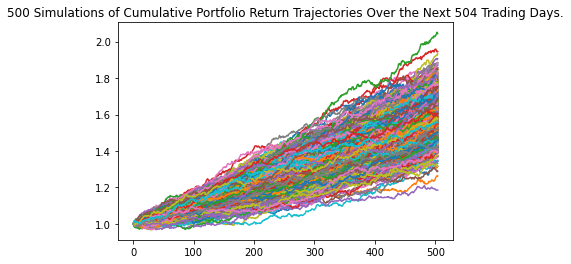

In [64]:
line_plot_low=MC_low_vol.plot_simulation()

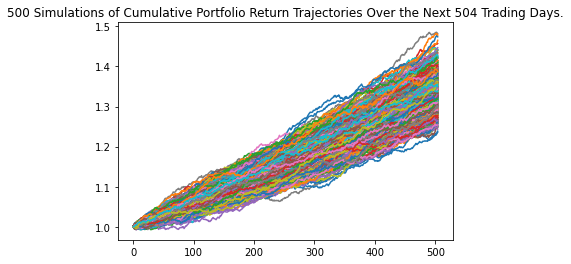

In [65]:
line_plot_high=MC_high_vol.plot_simulation()

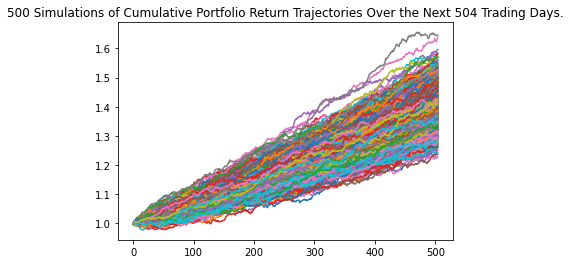

In [66]:
line_plot_rand=MC_rand_port.plot_simulation()

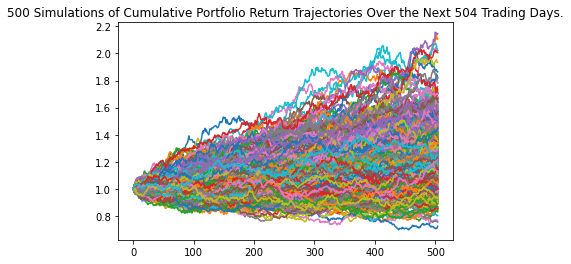

In [67]:
line_plot_index=MC_index_port.plot_simulation()

In [68]:
##Calculating portfolio returns for each option and return on a $10,000 invesment, specifically cumulative returns and the value of a $10,000 investment
#Starting first with low beta portfolio
initial_investment_low = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

low_vol_returns = low_vol.pct_change().dropna()
low_vol_returns.head()

,NEM,NFLX,AMD,VRTX,ABMD,BBY,MNST,INCY,TMUS,FCX,...,PRGO,IPGP,ALXN,TSN,OKE,AKAM,JNPR,DVN,HCA,URI
2012-01-04 00:00:00,-0.003061,0.113649,-0.003650,-0.000931,-0.007671,-0.019003,0.000973,-0.014009,-0.063898,0.008354,...,-0.035109,0.016983,-0.003968,0.002954,-0.000801,-0.014880,-0.013783,-0.011042,-0.038817,0.028315
2012-01-05 00:00:00,0.003393,-0.014295,0.000000,0.028571,0.008835,0.009040,0.013716,0.045332,-0.088737,-0.013307,...,0.011147,0.056777,0.030161,-0.004418,0.001030,-0.000308,-0.005301,-0.000153,0.023558,0.005037
2012-01-06 00:00:00,-0.002093,0.088146,-0.005495,0.028080,-0.007116,0.033276,0.016194,0.055016,0.001248,-0.010941,...,-0.000936,0.020806,0.028173,0.001972,-0.002630,0.010176,-0.010174,-0.009485,0.049319,-0.010023
2012-01-09 00:00:00,-0.007907,0.137791,0.029466,0.047871,0.003859,0.016515,0.005662,-0.001227,0.022444,0.004374,...,0.005205,0.017028,-0.002418,-0.011319,-0.005160,-0.004579,0.053842,0.016834,-0.030886,-0.005400
2012-01-10 00:00:00,0.019031,-0.023936,0.021467,0.017937,-0.002746,0.004062,-0.006985,-0.013514,0.012195,0.039959,...,0.031276,0.203196,0.005520,0.011946,0.016136,0.016253,-0.008825,-0.002126,0.037413,0.065830


<AxesSubplot:>

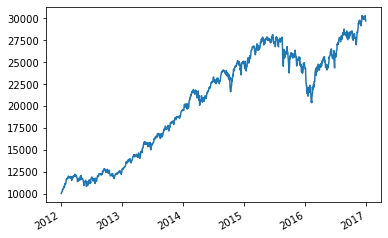

In [69]:
low_vol_combined = low_vol_returns.dot(weights)
low_vol_cumulative = (1 + low_vol_combined).cumprod()
low_vol_profit = initial_investment_low * low_vol_cumulative
low_vol_profit.plot()

In [70]:
#Calculating portfolio metrics for high beta portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_high = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

high_vol_returns = high_vol.pct_change().dropna()
high_vol_returns.head()

,AME,PNC,NOC,MCD,XRAY,CTAS,PGR,HSIC,GD,PG,...,AJG,CB,GL,L,CINF,JNJ,ADP,MMM,MMC,SPY
2012-01-04 00:00:00,0.013728,0.003219,-0.000511,0.005565,-0.000283,0.032917,-0.004137,-0.003041,0.001765,-0.000449,...,-0.015921,-0.009526,-0.006630,-0.012217,-0.004902,-0.006072,-0.001102,0.008264,-0.011314,0.001569
2012-01-05 00:00:00,0.016577,0.009963,-0.008187,0.004427,0.000848,0.003022,0.008827,0.010067,-0.010570,-0.004192,...,0.002442,0.002871,0.012198,0.001316,0.014121,-0.001222,0.007353,-0.004514,-0.009854,0.002662
2012-01-06 00:00:00,-0.011943,0.001672,-0.004299,0.007713,-0.005932,0.021912,0.004117,-0.001359,0.003264,-0.002405,...,0.002132,0.002433,-0.011824,-0.008673,-0.006800,-0.008716,0.001460,-0.005131,-0.013804,-0.002577
2012-01-09 00:00:00,0.000232,0.008179,0.000173,-0.009543,-0.004831,0.002144,0.002050,-0.003629,0.011091,0.004219,...,0.001519,0.004569,-0.002301,0.003181,0.009129,0.001542,-0.003827,0.005997,0.002279,0.002427
2012-01-10 00:00:00,0.023240,0.019371,0.012260,0.000602,0.014278,0.017384,0.003581,0.012293,0.022817,-0.004652,...,0.001517,0.006397,0.012223,0.016913,0.011955,0.004158,-0.000183,0.005127,0.007795,0.008671


<AxesSubplot:>

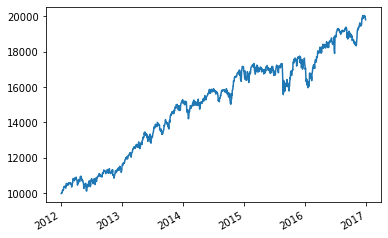

In [71]:
high_vol_combined = high_vol_returns.dot(weights)
high_vol_cumulative = (1 + high_vol_combined).cumprod()
high_vol_profit = initial_investment_high * high_vol_cumulative
high_vol_profit.plot()

In [72]:
#Calculating portfolio metrics for index portfolio (use ETF SPY as a proxy), specifically cumulative returns and the value of a $10,000 investment
initial_investment_index = 10000

index_port_returns = index_port.pct_change().dropna()
index_port_returns.head()

,SPY
Date,
2012-01-04,0.001569
2012-01-05,0.002662
2012-01-06,-0.002577
2012-01-09,0.002427
2012-01-10,0.008671


<AxesSubplot:xlabel='Date'>

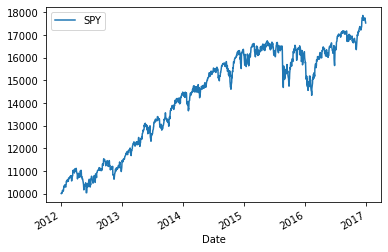

In [73]:
index_port_cumulative = (1 + index_port_returns).cumprod()
index_port_profit = initial_investment_index * index_port_cumulative
index_port_profit.plot()

In [74]:
#Calculating portfolio metrics for randomly selected portfolio, specifically cumulative returns and the value of a $10,000 investment
initial_investment_rand = 10000
weights = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

rand_port_returns = rand_port.pct_change().dropna()
rand_port_returns.head()

,SLB,KIM,DXC,V,CMI,STX,TT,ROK,MCO,MAS,...,HD,USB,EL,ADP,BSX,CMCSA,CMA,TPR,CVX,LYV
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.007562,-0.015644,-0.001224,-0.017866,0.013729,0.023737,-0.007477,0.008987,-0.002560,0.019126,...,0.014238,-0.000363,0.003825,-0.001102,-0.009328,0.009388,0.002994,0.025816,-0.001722,0.027203
2012-01-05,-0.021420,0.017115,-0.007350,0.007514,0.026002,0.064209,0.011299,-0.007205,0.017679,0.031278,...,0.008189,0.014871,-0.001684,0.007353,0.005650,0.008896,0.021642,0.004384,-0.009802,0.008475
2012-01-06,-0.004260,-0.011418,-0.032086,-0.011775,-0.012355,0.022346,-0.006207,-0.044993,0.003923,-0.012132,...,0.002553,-0.008220,-0.010384,0.001460,-0.007491,-0.010421,0.019722,0.012609,-0.007241,0.014706
2012-01-09,0.015344,-0.010942,-0.006800,-0.008043,0.028654,-0.006011,0.013429,0.010500,0.000000,0.000000,...,0.000694,0.017658,-0.003587,-0.003827,0.009434,0.021061,0.015759,0.003512,0.010895,0.008282
2012-01-10,0.028044,0.022127,0.044502,-0.001001,0.026193,0.022540,0.020955,0.023517,0.013955,0.005263,...,0.006940,0.000708,0.009001,-0.000183,0.033645,0.007537,0.004584,-0.008591,-0.003927,0.032854


<AxesSubplot:xlabel='Date'>

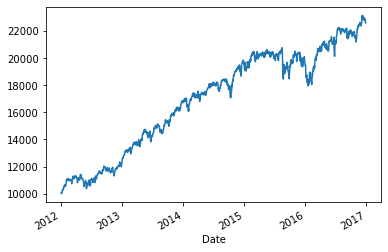

In [75]:
rand_port_combined = rand_port_returns.dot(weights)
rand_port_cumulative = (1 + rand_port_combined).cumprod()
rand_port_profit = initial_investment_rand * rand_port_cumulative
rand_port_profit.plot()

In [76]:
#Plotting using hv plot, the cumulative value of an initial investment of $10K in each of the portfolios over time
low_vol_plot = low_vol_profit.hvplot(label='Low Beta Portfolio')
high_vol_plot = high_vol_profit.hvplot(label='High Beta Portfolio')
rand_port_plot = rand_port_profit.hvplot(label="Randomly Selected Portfolio")
index_plot = index_port_profit.hvplot(label="Index Portfolio (Base Case)")

index_plot + low_vol_plot + high_vol_plot + rand_port_plot

:Layout
   .Curve.Index_Portfolio_left_parenthesis_Base_Case_right_parenthesis :Curve   [Date]   (SPY)
   .Curve.Low_Beta_Portfolio                                           :Curve   [index]   (0)
   .Curve.High_Beta_Portfolio                                          :Curve   [index]   (0)
   .Curve.Randomly_Selected_Portfolio                                  :Curve   [Date]   (0)

In [77]:
# Calculating sharpe ratios for each portfolio in order to determine risk adjusted return
# Sharpe ratio of low beta portfolio
low_sharpe = (low_vol_combined.mean() * 252) / (low_vol_combined.std() * np.sqrt(252))
low_sharpe

1.3489294509090972

In [78]:
# Sharpe ratio of high beta portfolio
high_sharpe = (high_vol_combined.mean() * 252) / (high_vol_combined.std() * np.sqrt(252))
high_sharpe

1.1906534146672536

In [79]:
# Sharpe ratio of index portfolio
index_sharpe = (index_port_returns.mean() * 252) / (index_port_returns.std() * np.sqrt(252))
index_sharpe

SPY    0.939578
dtype: float64

In [80]:
# Sharpe ratio of randomly selected portfolio
rand_sharpe = (rand_port_combined.mean() * 252) / (rand_port_combined.std() * np.sqrt(252))
rand_sharpe

1.2537418655767374

In [81]:
# Creating a dataframe combinging all four portfolio returns, joined on a common index of date
combined_port_returns = pd.concat(
    [low_vol_combined, high_vol_combined, rand_port_combined, index_port_returns], axis=1, join="inner"
)
combined_port_returns

,0,1,2,SPY
2012-01-04,0.000170,-0.002112,0.001758,0.001569
2012-01-05,0.009087,0.003155,0.007947,0.002662
2012-01-06,0.005432,-0.001891,-0.003570,-0.002577
2012-01-09,0.004706,0.002766,0.001979,0.002427
2012-01-10,0.016241,0.010182,0.010978,0.008671
...,...,...,...,...
2016-12-23,0.007883,0.000482,0.001001,0.001464
2016-12-27,0.006222,0.000944,0.001911,0.002481
2016-12-28,-0.012419,-0.007854,-0.009303,-0.008265
2016-12-29,-0.000354,0.000372,0.000411,-0.000223


<AxesSubplot:>

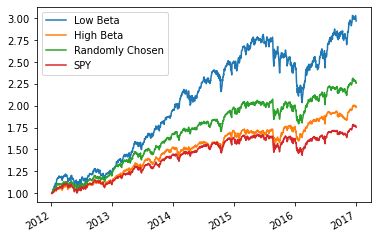

In [83]:
# Calculating cumulative returns for each of the four portfolios and plotting results
combined_port_returns.rename(columns={0: "Low Beta", 1 : "High Beta", 2: "Randomly Chosen"}, inplace=True)
cumulative_port_returns = (1 + combined_port_returns).cumprod()
cumulative_port_returns.plot()

In [84]:
# Calculating the correlation of daily returns among the four different portfolios and visualizsing via seaborn heatmap
correlation = combined_port_returns.corr()
correlation

,Low Beta,High Beta,Randomly Chosen,SPY
Low Beta,1.000000,0.826846,0.898517,0.889593
High Beta,0.826846,1.000000,0.948899,0.960667
Randomly Chosen,0.898517,0.948899,1.000000,0.957586
SPY,0.889593,0.960667,0.957586,1.000000


<AxesSubplot:>

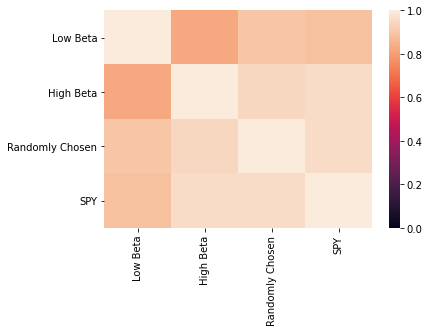

In [85]:
sns.heatmap(correlation, vmin=-0, vmax=1)